# Investigating A Movie DataSet
<br />  
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#import">Import libraries</a></li>
<li><a href="#clean">Data cleaning</a></li>
<li><a href="#Json">Json format</a></li>
<li><a href="#genre">Genre and year</a></li>
<li><a href="#UP">Universal Pictures and Paramount Pictures</a></li>
<li><a href="#novel">Based on novel</a></li>
</ul>

<a id = 'intro'></a>
### Introduction
> This data set contains information about 10,000 movies collected from The Movie Database (TMDb)
<br />
> ** Questions To Explore **
> > <p style="color: #00FFFF">1.What change in movie type over time？</p>
> > <p style="color: #00FFFF">2.What the mean of popularity between Universal Pictures and Paramount Pictures？</p>
> > <p style="color: #00FFFF">1.What profit development in novel and orignal？</p>

<a id = 'import'></a>
### import libraries

<a id='intro'></a>

In [1]:
import pandas as pd
import numpy as np
#。pyplot 它名字就是这样的啦
import matplotlib.pyplot as plt
import seaborn as sns 
#显示白表格，可以改成黑的试试
sns.set_style("whitegrid") 
#在notebook中显示图片，而不是在别的窗口中
%matplotlib inline
#忽略警告
import warnings
warnings.filterwarnings('ignore')
import json
from datetime import datetime

<a id = 'clean'></a>
### Data cleaning

In [2]:
#导入数据，并删除无关项
movies_Df = pd.read_csv('./tmdb_5000_movies.csv')
credits_Df = pd.read_csv('./tmdb_5000_credits.csv')
movies_Df = movies_Df.drop(['homepage', 'id', 'original_title', 'overview', 'status', 'tagline'\
                , 'original_language', 'title'], axis = 1)
credits_Df = credits_Df.drop('movie_id', axis = 1)
full = pd.concat([movies_Df, credits_Df], axis = 1)

#将title列换到第一列
title = full['title']
full.drop('title', axis = 1, inplace = True)
#错误记录：  在插入title列时，因为有两个title列， 导致insert函数失败， 所以应该在上面先删除一个title列
full.insert(0, 'title', title)

#填补runtime的缺失值，删除release_date的
full['runtime'] = full['runtime'].fillna(full['runtime'].mean())
#可以成功 full为一个DF类型
full = full.dropna()
#失败。原因探究中 full.release_date为Series类型
#full.release_date = full.release_date.dropna()
#用于找到缺失值的位置
#full[full['release_date'].isnull()] 
#用于查看是否有缺失值
#full.info()

<a id = 'Json'></a>
### Json format

In [3]:
#选定列JOSN化函数
def load_JSON(df):
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages', \
                   'cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#join 以指定字符连接为一个新字符
def get_genres(keywords):
    return '|'.join(x['name'] for x in keywords)

full = load_JSON(full)
full['genres'] = full['genres'].apply(get_genres)
#可以得到genre
#full['genres'][0][1]['name']

<a id = 'genre'></a>
### Genre and year

In [4]:
#获取所有可能的类型
list_genres = set()
for s in full['genres'].str.split('|'):
    list_genres = set().union(s, list_genres)
list_genres = list(list_genres)
list_genres.remove('')

In [5]:
#时间转换
t = full['release_date']
t = pd.to_datetime(t)
t = t.dt.year
full['release_date'] = t

In [6]:
#删除异常值，不是为空，而是''，因为用isnull无法判断，为强异常值
for i, j in zip(full['genres'].index, full['genres']):
    if j == '':
        full['genres'].drop(i, axis = 0, inplace = True)

In [7]:
#获得起始年份和结束年份
min_year = full['release_date'].min()
max_year = full['release_date'].max()
#print(min_year, max_year)

In [8]:
#创建一个年份和类型的数据框
genres_df = pd.DataFrame(index = range(min_year, max_year+1), columns = list_genres)
genres_df = genres_df.fillna(value = 0)

#对数据框进行赋值，每出现一个类型，则在对应的年份，+1
for genre, year in zip(full['genres'], full['release_date']):
    #错误记录： n = len(genre) 因为genre是字符串类型，所以导致n为40，超出了界限
    #year 为int型
    split_genre = list(genre.split('|'))
    #split_genre.remove('')      
    n = len(split_genre)
    #print(split_genre) #形式正确
    for i in range(n):
        j = split_genre[i] 
        genres_df.ix[year, j] += 1

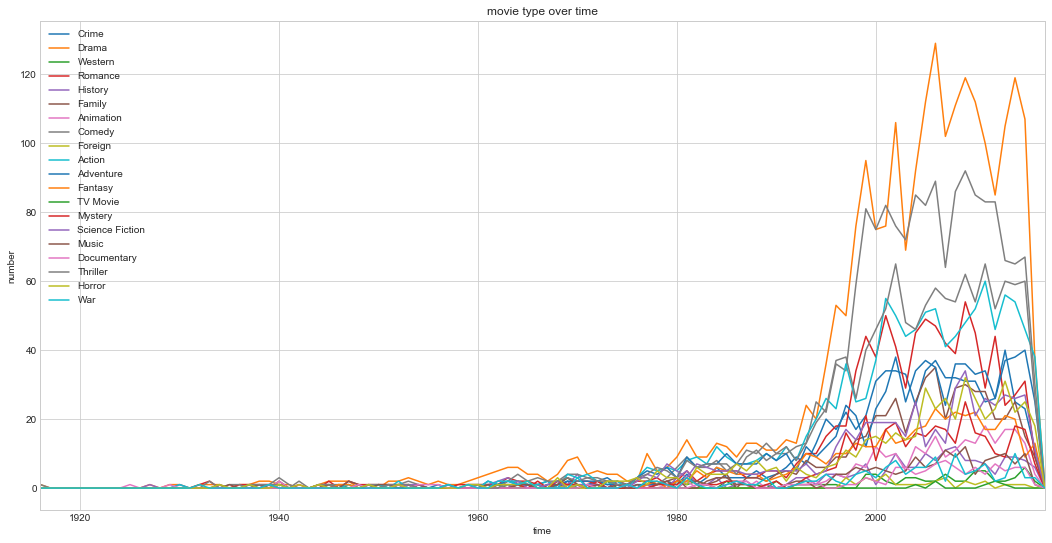

In [9]:
#画折线图啦！！！第六天。。。
genres_df.plot(x = genres_df.index, figsize = (18, 9))
plt.xlabel('time')
plt.ylabel('number')
plt.title('movie type over time')
plt.show()

<a id = 'UP'></a>
### Universal Pictures and Paramount Pictures

In [10]:
#单独筛选出需要测量的变量
UP_df = full[['production_companies', 'popularity']]

In [11]:
#计算两个公司的平均流行度
list1 = []
for u,p in zip(UP_df['production_companies'], UP_df['popularity']):
    n = len(u)
    for i in range(n):
        if u[i]['name'] == 'Universal Pictures':
            list1.append(p)
list2 = []
for u,p in zip(UP_df['production_companies'], UP_df['popularity']):
    n = len(u)
    for i in range(n):
        if u[i]['name'] == 'Paramount Pictures':
            list2.append(p)
def average(seq, total=0.0):
    num = 0   
    for item in seq:      
        total += item      
        num += 1   
    return total / num, total
mean_U, total_U = average(list1)
mean_P, total_P = average(list2)

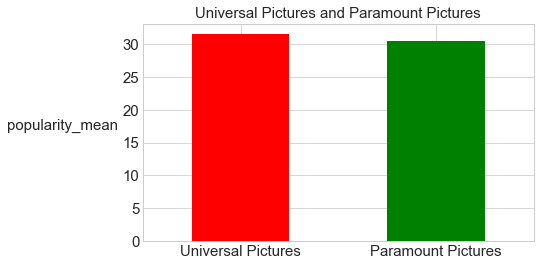

In [12]:
#total备用做并列条形图
UP_df = pd.Series(['mean_U', 'mean_P'], index = ['Universal Pictures', 'Paramount Pictures'])
UP_df['Universal Pictures'] = mean_U
UP_df['Paramount Pictures'] = mean_P
ax = UP_df.plot(kind = 'bar', figsize = (7,4), color = 'rgb', fontsize = 15, rot = 0)
plt.ylabel('popularity_mean', fontsize = 15, rotation = 0, labelpad = 60)
plt.title('Universal Pictures and Paramount Pictures', fontsize = 15)
plt.grid(True)

<a id = 'novel'></a>
### based on novel

In [13]:
bonDF = full[['keywords', 'budget', 'revenue']]

In [14]:
def get_novel(keywords):
    return '|'.join( [x['name'] for x in keywords] )
bonDF['keywords'] = bonDF['keywords'].apply(get_novel)

In [23]:
#筛选出budget， revenue不等于0的数
bonDF = bonDF[bonDF['budget'] != 0]
bonDF = bonDF[bonDF['revenue'] != 0]

#非常漂亮的一行语句，直接二分映射
bonDF['base_on_novel'] = bonDF['keywords'].str.contains('based on novel')\
                                .map( {True:'based on novel', False:'orignal'} )
#纠结了许久许久的选择，原来筛选自己需要的那一列如此简单
novel = bonDF[bonDF['base_on_novel'] == 'based on novel']
orignal = bonDF[bonDF['base_on_novel'] == 'orignal']

In [49]:
#留下曾经 蠢萌的尝试， 为了区分出 原创电影

#def dec_novel(x):
#    if x == 'based on novel':
#        return x
#novel['base_on_novel'] = bonDF['base_on_novel'].map\
#                            (dec_novel, bonDF['base_on_novel'])

'''dfjsodfjsdif'''
#消除多行注释的 模拟输出
pass

In [29]:
novel['profit'] = novel['revenue'] - novel['budget']
orignal['profit'] = orignal['revenue'] - orignal['budget']

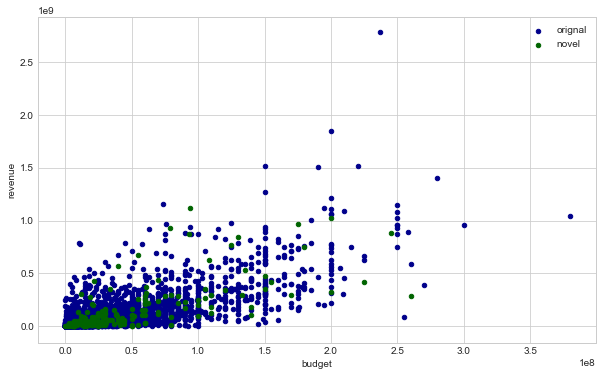

In [47]:
ax = orignal.plot.scatter(x='budget', y='revenue', color='DarkBlue', label='orignal', figsize = (10, 6))
novel.plot.scatter(x='budget', y='revenue', color='DarkGreen', label='novel', ax=ax)